In [3]:
!nvidia-smi
%env CUDA_VISIBLE_DEVICES=1

Fri Aug 29 08:58:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:25:00.0 Off |                    0 |
| N/A   36C    P0             65W /  300W |    1575MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [5]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
import torchvision.transforms.v2 as v2

import numpy as np
import pandas as pd
import math
from pathlib import Path
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
from itertools import chain, pairwise
import random
from tqdm import tqdm
import sys
import os
from multiprocessing import Pool
import pickle

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
)
from sklearn.preprocessing import LabelEncoder

sys.path.append('./src')
from src.data import MultiSet, ImageTransformTest, ProfileTransformTest
from src.model import MultiModel
from src.ann import ANNClassifier

from lightning import Trainer
import logging

import scienceplots
plt.style.use('science')

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 10
})

import timm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from pacmap import PaCMAP

# Encode normalized embeddings from data folds

Considers cross-data setups, where both models, and test set has folds.

Designed to encode lab data with models pre-trained with lab data.
* train split -> gallery
* test split -> inference data


In [ ]:
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

traindata = 'FASTVISION-plus'

names = (
    f'efficientnet_b0_cnn_2_512_clip_{traindata}',
    f'efficientnet_b0_cnn_2_512_siglip_{traindata}',
    f'vit_t_16_transformer_2_512_clip_{traindata}',
    f'vit_t_16_transformer_2_512_siglip_{traindata}',
)

embeddings = {name: {} for name in names}

image_transforms = ImageTransformTest(224)
signal_transforms = ProfileTransformTest(224)

I = 5 # model folds

for name in names: 

    for i in range(1, I + 1):

        # Verify the right checkpoint path
        path = Path(f'logs/{name}_fold{i}/version_1/checkpoints')
            
        checkpoint = list(path.iterdir())[0]
        print(checkpoint)

        model = MultiModel.load_from_checkpoint(checkpoint)

        def multi_collate(batch, model=model):
    
            image, profile, label, image_shape, profile_len = zip(*(sample.values() for sample in batch))
    
            image = {'image': torch.stack(image)}
            profile = model.profile_encoder.tokenize(profile)
            label = {'label': label}
            image_shape = {'image_shape': torch.stack(image_shape)}
            profile_len = {'profile_len': torch.stack(profile_len)}
    
            return image | profile | label | image_shape | profile_len
        
            # change test data path here

        data_path = Path(f'./data/FASTVISION-plus/fold{i}')

        train_set = MultiSet(annotation_path=data_path / f'train.csv', 
                            image_transforms=image_transforms,
                            profile_transform=signal_transforms)

        test_set = MultiSet(annotation_path=data_path / f'test.csv', 
                            image_transforms=image_transforms,
                            profile_transform=signal_transforms)
    
        train_loader = DataLoader(dataset=train_set, batch_size=128, 
                                    num_workers=8, collate_fn=multi_collate)
    
        test_loader = DataLoader(dataset=test_set, batch_size=128, 
                                    num_workers=8, collate_fn=multi_collate)
    
        trainer = Trainer(barebones=True)
    
        train = trainer.predict(model, train_loader)
        image_train, profile_train, label_train = zip(*(sample.values() for sample in train))
    
        test = trainer.predict(model, test_loader)
        image_test, profile_test, label_test = zip(*(sample.values() for sample in test))

        I_train = F.normalize(torch.cat(image_train)).numpy()
        P_train = F.normalize(torch.cat(profile_train)).numpy()
        L_train = np.concatenate(label_train)
    
        I_test = F.normalize(torch.cat(image_test)).numpy()
        P_test = F.normalize(torch.cat(profile_test)).numpy()
        L_test = np.concatenate(label_test)

        embeddings[name][i + I * (j - 1)] = {
            'train': {
                'image': I_train,
                'profile': P_train,
                'label': L_train,
            },
            'test': {
                'image': I_test,
                'profile': P_test,
                'label': L_test,
            },
            'classes': np.unique(L_train)
        }

logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold1/version_1/checkpoints/epoch=86_valid_loss=0.92302.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold2/version_1/checkpoints/epoch=71_valid_loss=0.92090.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold3/version_1/checkpoints/epoch=85_valid_loss=0.95849.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold4/version_1/checkpoints/epoch=101_valid_loss=0.90174.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold5/version_1/checkpoints/epoch=100_valid_loss=0.89586.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold1/version_1/checkpoints/epoch=77_valid_loss=2.28052.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold2/version_1/checkpoints/epoch=121_valid_loss=2.08915.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold3/version_1/checkpoints/epoch=107_valid_loss=2.16409.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold4/version_1/checkpoints/epoch=40_valid_loss=2.56722.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold5/version_1/checkpoints/epoch=72_valid_loss=2.25645.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_clip_FASTVISION-plus_fold1/version_1/checkpoints/epoch=39_valid_loss=1.56494.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_clip_FASTVISION-plus_fold2/version_1/checkpoints/epoch=40_valid_loss=1.54303.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_clip_FASTVISION-plus_fold3/version_1/checkpoints/epoch=48_valid_loss=1.51763.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_clip_FASTVISION-plus_fold4/version_1/checkpoints/epoch=42_valid_loss=1.57380.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_clip_FASTVISION-plus_fold5/version_1/checkpoints/epoch=65_valid_loss=1.48764.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_siglip_FASTVISION-plus_fold1/version_1/checkpoints/epoch=59_valid_loss=2.72835.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_siglip_FASTVISION-plus_fold2/version_1/checkpoints/epoch=67_valid_loss=2.67641.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_siglip_FASTVISION-plus_fold3/version_1/checkpoints/epoch=61_valid_loss=2.69852.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_siglip_FASTVISION-plus_fold4/version_1/checkpoints/epoch=67_valid_loss=2.70402.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_siglip_FASTVISION-plus_fold5/version_1/checkpoints/epoch=87_valid_loss=2.69961.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


# Encode full data with model folds

More straight forward pipeline, where the whole data is encoded.

In [ ]:
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

# traindata = 'FASTVISION-plus'
traindata = 'CS_103_Uto2024'

names = (
    f'efficientnet_b0_cnn_2_512_clip_{traindata}',
    f'efficientnet_b0_cnn_2_512_siglip_{traindata}',
    f'vit_t_16_transformer_2_512_clip_{traindata}',
    f'vit_t_16_transformer_2_512_siglip_{traindata}',
)

embeddings = {name: {} for name in names}

image_transforms = ImageTransformTest(224)
signal_transforms = ProfileTransformTest(224)

I = 5 # model folds

for name in names: 
    for i in range(1, I + 1):
        # Verify the right checkpoint path
        path = Path(f'logs/{name}_fold{i}/version_0/checkpoints')
        # path = Path(f'logs/{name}_fold{i}/version_1/checkpoints')
            
        checkpoint = list(path.iterdir())[0]
        print(checkpoint)

        model = MultiModel.load_from_checkpoint(checkpoint)

        def multi_collate(batch, model=model):
    
            image, profile, label, image_shape, profile_len = zip(*(sample.values() for sample in batch))
    
            image = {'image': torch.stack(image)}
            profile = model.profile_encoder.tokenize(profile)
            label = {'label': label}
            image_shape = {'image_shape': torch.stack(image_shape)}
            profile_len = {'profile_len': torch.stack(profile_len)}
    
            return image | profile | label | image_shape | profile_len
        
        # change test data path here
        data_path = Path(f'./data/CytoSense')

        data_set = MultiSet(annotation_path=data_path / f'annotations.csv', 
                           image_transforms=image_transforms,
                           profile_transform=signal_transforms)

        data_loader = DataLoader(dataset=data_set, batch_size=128, 
                                  num_workers=8, collate_fn=multi_collate)
    
        trainer = Trainer(barebones=True)
    
        out = trainer.predict(model, data_loader)
        images, profiles, labels = zip(*(sample.values() for sample in out))
    
        images = F.normalize(torch.cat(images)).numpy()
        profiles = F.normalize(torch.cat(profiles)).numpy()
        labels = np.concatenate(labels)

        embeddings[name][i] = {
            'image': images,
            'profile': profiles,
            'label': labels,
            'classes': np.unique(labels)
        }

logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold1/version_1/checkpoints/epoch=86_valid_loss=0.92302.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold2/version_1/checkpoints/epoch=71_valid_loss=0.92090.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold3/version_1/checkpoints/epoch=85_valid_loss=0.95849.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold4/version_1/checkpoints/epoch=101_valid_loss=0.90174.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold5/version_1/checkpoints/epoch=100_valid_loss=0.89586.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold1/version_1/checkpoints/epoch=77_valid_loss=2.28052.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold2/version_1/checkpoints/epoch=121_valid_loss=2.08915.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold3/version_1/checkpoints/epoch=107_valid_loss=2.16409.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold4/version_1/checkpoints/epoch=40_valid_loss=2.56722.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold5/version_1/checkpoints/epoch=72_valid_loss=2.25645.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_clip_FASTVISION-plus_fold1/version_1/checkpoints/epoch=39_valid_loss=1.56494.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_clip_FASTVISION-plus_fold2/version_1/checkpoints/epoch=40_valid_loss=1.54303.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_clip_FASTVISION-plus_fold3/version_1/checkpoints/epoch=48_valid_loss=1.51763.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_clip_FASTVISION-plus_fold4/version_1/checkpoints/epoch=42_valid_loss=1.57380.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_clip_FASTVISION-plus_fold5/version_1/checkpoints/epoch=65_valid_loss=1.48764.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_siglip_FASTVISION-plus_fold1/version_1/checkpoints/epoch=59_valid_loss=2.72835.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_siglip_FASTVISION-plus_fold2/version_1/checkpoints/epoch=67_valid_loss=2.67641.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_siglip_FASTVISION-plus_fold3/version_1/checkpoints/epoch=61_valid_loss=2.69852.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_siglip_FASTVISION-plus_fold4/version_1/checkpoints/epoch=67_valid_loss=2.70402.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_siglip_FASTVISION-plus_fold5/version_1/checkpoints/epoch=87_valid_loss=2.69961.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


# Save for benchmarks

In [ ]:
with open('embeddings_labmodels_with_sea_raw.pkl', 'wb') as buf:
    pickle.dump(embeddings, buf)

# Display results

First, run benchmark scripts needed in your case:

* `scripts/benchmark_raw.py`: No folds in test data.
* `scripts/benchmark_folds.py`: Folds in test data.

Use `--help` for more details. Scripts also have few parameters to configure,
*if needed*.

Note, the search tree buildup is not deterministic, so script sets seeds to
reproduce results.

Also, ANN can be finetuned to prefer speed over accuracy and vice versa.
Current configuration prefers accuracy to mimic deterministc NN-search.
See pynndescent docs for more information.

After running script(s), you end up a following dict structures:

```
results = {
    model_name (str): {
        fold (Any): {
            n_per_class_in_gallery (int): subresults
            ...
        }
        ...
    } 
    ...
}
```
where
```
subresults = {
    simulation_id (Any): {
        'true': ndarray
        'pred': {
            k_neighbors_in_search (int): ndarray
            ...
        }
    }
    ... 
}
```
I know, what a mess. But this provides the possibility for any form of visualization for the results.

Moreover, "Any" can be any type. In the scripts they are integers counting from 0.

In [20]:
with open('./results_utomodels_with_sea_raw.pkl', 'rb') as buf:
    results = pickle.load(buf)

# Gather utility functions and variables, and configuration parameters
# Note: in all cases, "retrieved neighbors" > "number of samples per class in gallery"

NAMES = list(results)
FOLDS = list(results[NAMES[0]])
N = list(results[NAMES[0]][FOLDS[0]])
SIMS = list(results[NAMES[0]][FOLDS[0]][N[-1]])
K = list(results[NAMES[0]][FOLDS[0]][N[-1]][SIMS[0]]['pred'])
coder = LabelEncoder().fit(results[NAMES[0]][FOLDS[0]][N[-1]][SIMS[0]]['true'])

def to_latin(key):
    key_new = key.replace('-', '_')
    key_new = key_new.replace(' ', '_')
    pieces = key_new.split('_')
    return ' '.join(pieces)

def to_latex(name):
    pieces = name.split(' ')
    if len(pieces) == 1:
        title = f'\\textit{{{name}}}'
    else:
        title = ('\\textit{{{}}} ' * len(pieces)).format(*pieces)[:-1]
    title = title.replace('\\textit{sp}', 'sp.')
    title = title.replace('\\textit{like}', 'like')
    title = title.replace('\\textit{single}', 'single')
    title = title.replace('\\textit{coiled}', 'coiled')
    title = title.replace('\\textit{Small}', 'Small')
    title = title.replace('\\textit{centric}', 'centric')
    return title

pretty_names = {
    'efficientnet_b0_cnn_2_512_clip_FASTVISION-plus': 'EfficientNet_B0 + CNN_2 + CLIP',
    'efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus': 'EfficientNet_B0 + CNN_2 + SigLip',
    'vit_t_16_transformer_2_512_clip_FASTVISION-plus': 'ViT_T/16 + Transformer_2 + CLIP',
    'vit_t_16_transformer_2_512_siglip_FASTVISION-plus': 'ViT_T/16 + Transformer_2 + SigLip',
    'efficientnet_b0_cnn_2_512_clip_CS_103_Uto2024': 'EfficientNet_B0 + CNN_2 + CLIP',
    'efficientnet_b0_cnn_2_512_siglip_CS_103_Uto2024': 'EfficientNet_B0 + CNN_2 + SigLip',
    'vit_t_16_transformer_2_512_clip_CS_103_Uto2024': 'ViT_T/16 + Transformer_2 + CLIP',
    'vit_t_16_transformer_2_512_siglip_CS_103_Uto2024': 'ViT_T/16 + Transformer_2 + SigLip',
}

print('NAMES =', ' | '.join(NAMES))
print('FOLDS =', ' | '.join(map(str, FOLDS)))
print('N =', ' | '.join(map(str, N)))
print('SIMS =', ' | '.join(map(str, SIMS)))
print('K =', ' | '.join(map(str, K)))

NAMES = efficientnet_b0_cnn_2_512_clip_CS_103_Uto2024 | efficientnet_b0_cnn_2_512_siglip_CS_103_Uto2024 | vit_t_16_transformer_2_512_clip_CS_103_Uto2024 | vit_t_16_transformer_2_512_siglip_CS_103_Uto2024
FOLDS = 1 | 2 | 3 | 4 | 5
N = 2 | 4 | 8 | 12 | 16
SIMS = 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19
K = 1 | 3 | 5 | 7 | 9


## Full table for given $n$

Optionally: specify the k(s), fold(s) and simulation(s)

In [7]:
n = 256 # <- change here
k_vals = K[:] # <- give k(s) as a list
folds = FOLDS[:] # <- give fold(s) as a list
sims = SIMS[:] # <- give sim(s) as a list
metrics = {}

for name in NAMES:
    metrics[name] = {k: [] for k in k_vals}
    for fold in folds:
        sub = results[name][fold][n]
        for sim in sims:
            true = coder.transform(sub[sim]['true'])
            for k in k_vals:
                pred = coder.transform(sub[sim]['pred'][k])
                acc = accuracy_score(true, pred)
                rest = precision_recall_fscore_support(true, pred, average='macro')
                metrics[name][k].append((acc,) + rest[:-1])

    print(f'{pretty_names[name]}:')
    for k in k_vals:
        data = metrics[name][k]
        mu = np.mean(data, 0)
        std = np.std(data, 0)
        vals = chain(*zip(mu, std))
        print(f'k={k:3d}' + (' {:.2%}' * 8).format(*vals))
    print()


EfficientNet_B0 + CNN_2 + CLIP:
k=  1 92.92% 0.35% 91.91% 0.40% 92.26% 0.42% 91.97% 0.42%
k=  3 95.97% 0.27% 95.33% 0.33% 95.59% 0.30% 95.39% 0.33%
k=  9 96.20% 0.28% 95.59% 0.34% 95.81% 0.31% 95.63% 0.34%
k= 15 95.95% 0.30% 95.32% 0.35% 95.51% 0.32% 95.33% 0.36%
k= 31 95.27% 0.33% 94.61% 0.39% 94.74% 0.36% 94.55% 0.40%
k= 51 94.54% 0.35% 93.85% 0.40% 93.89% 0.38% 93.71% 0.42%

EfficientNet_B0 + CNN_2 + SigLip:
k=  1 92.60% 0.38% 91.61% 0.42% 92.02% 0.40% 91.69% 0.41%
k=  3 95.78% 0.27% 95.15% 0.28% 95.41% 0.28% 95.21% 0.29%
k=  9 96.03% 0.29% 95.46% 0.30% 95.63% 0.30% 95.47% 0.31%
k= 15 95.77% 0.32% 95.20% 0.33% 95.34% 0.33% 95.18% 0.34%
k= 31 95.14% 0.37% 94.53% 0.37% 94.60% 0.39% 94.45% 0.41%
k= 51 94.45% 0.45% 93.81% 0.43% 93.82% 0.48% 93.68% 0.49%

ViT_T/16 + Transformer_2 + CLIP:
k=  1 93.60% 0.25% 92.52% 0.27% 92.80% 0.28% 92.59% 0.27%
k=  3 95.76% 0.17% 95.05% 0.20% 95.23% 0.21% 95.10% 0.21%
k=  9 95.99% 0.17% 95.41% 0.20% 95.45% 0.20% 95.38% 0.20%
k= 15 95.81% 0.17% 95.23% 0.2

## Accuracy w.r.t. $n$, given $k$

Optionally: specify the n(s), fold(s) and simulation(s)

EfficientNet_B0 + CNN_2 + CLIP:   0%|          | 0/5 [00:00<?, ?it/s]

ViT_T/16 + Transformer_2 + SigLip: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


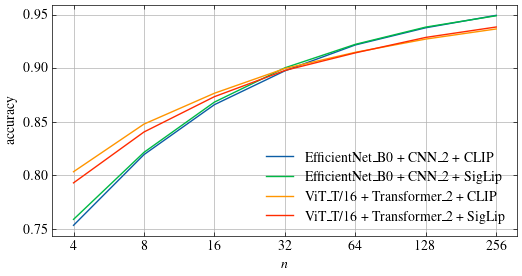

In [5]:
k = 3 # <- change here
n_vals = N[:] # <- give n(s) as a list
n_vals.remove(12)
folds = FOLDS[:] # <- give fold(s) as a list
sims = SIMS[:] # <- give sim(s) as a list
fig, ax = plt.subplots(figsize=(6, 3))

# Optionally, inlcude "upper bound" from previous results
# mu = 0.9910
# ax.plot((N[0], N[-1]), (mu, mu), 'k--', label='Name_of_the_model')

for name in NAMES:
    accs = {n: [] for n in n_vals}
    for fold in tqdm(folds, desc=pretty_names[name]):
        for n in n_vals:
            sub = results[name][fold][n]
            for sim in sims:
                true = coder.transform(sub[sim]['true'])
                pred = coder.transform(sub[sim]['pred'][k])
                acc = accuracy_score(true, pred)
                accs[n].append(acc)
    y = list(accs.values())
    ax.plot(n_vals, np.mean(y, 1), label=pretty_names[name])


ax.set_xlabel('$n$')
ax.set_ylabel('accuracy')
ax.set_xscale('log')
ax.minorticks_off()
ax.set_xticks(n_vals, n_vals)
ax.legend()
ax.grid()
plt.savefig('figures/subset_lab_lab_extra.pdf')

## Confusion matrices, given $n$ and $k$

Optionally: specify the fold(s) and simulation(s)

EfficientNet_B0 + CNN_2 + CLIP: 100%|██████████| 5/5 [00:00<00:00,  9.84it/s]
/tmp/ipykernel_1332661/3551529722.py:30: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 2 Axes> than <Figure size 350x262.5 with 2 Axes> which fig.colorbar is called on.
  plt.colorbar(cm.im_, cax=cax) # Similar to fig.colorbar(im, cax = cax)
EfficientNet_B0 + CNN_2 + SigLip: 100%|██████████| 5/5 [00:00<00:00, 10.29it/s]
/tmp/ipykernel_1332661/3551529722.py:30: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 2 Axes> than <Figure size 350x262.5 with 2 Axes> which fig.colorbar is called on.
  plt.colorbar(cm.im_, cax=cax) # Similar to fig.colorbar(im, cax = cax)
ViT_T/16 + Transformer_2 + CLIP: 100%|██████████| 5/5 [00:00<00:00, 10.44it/s]
/tmp/ipykernel_1332661/3551529722.py:30: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 2 Axes> than <Figure size 350x262.5 with 2 Axes> which fig.colorbar is called on.
  plt.colorbar(cm

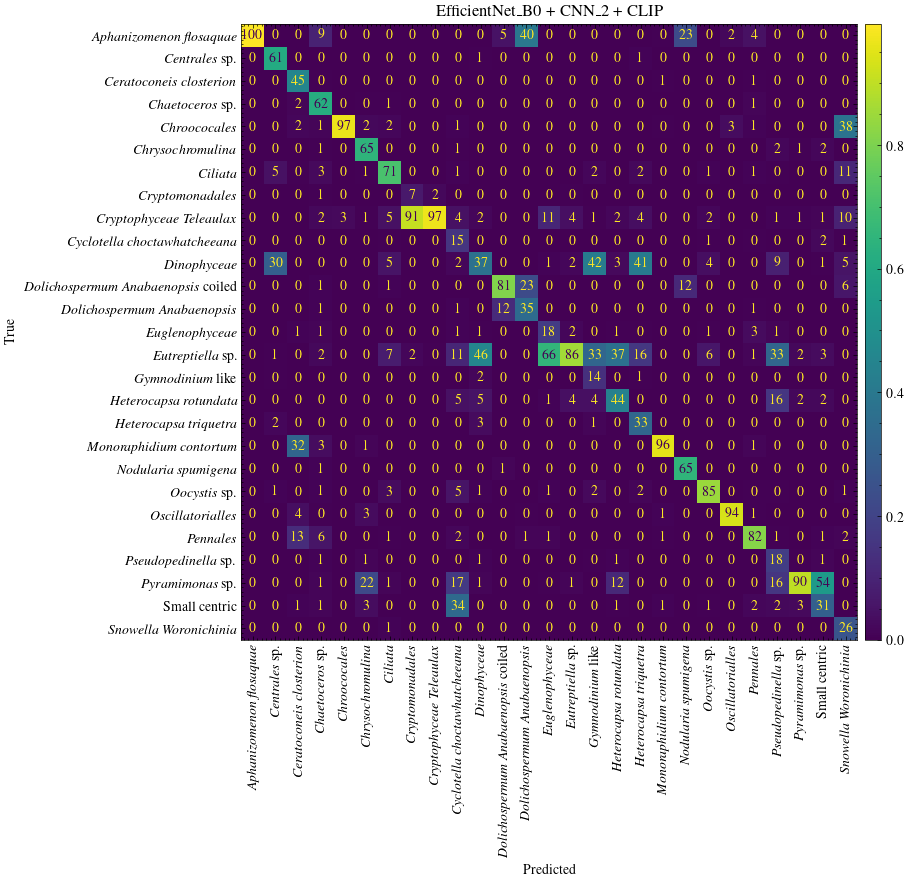

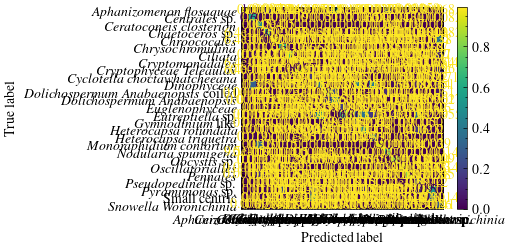

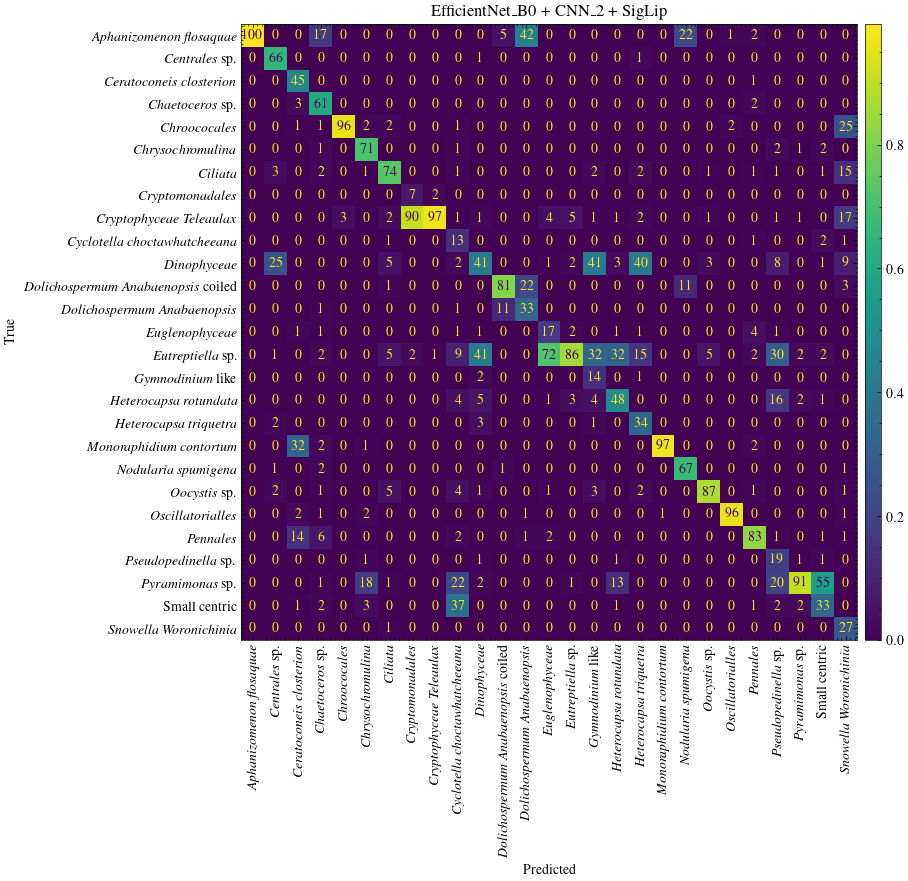

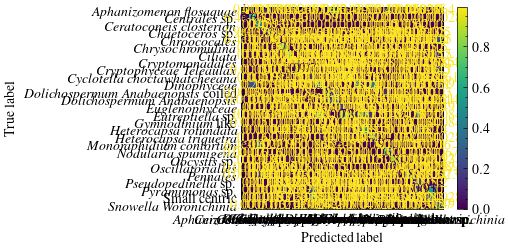

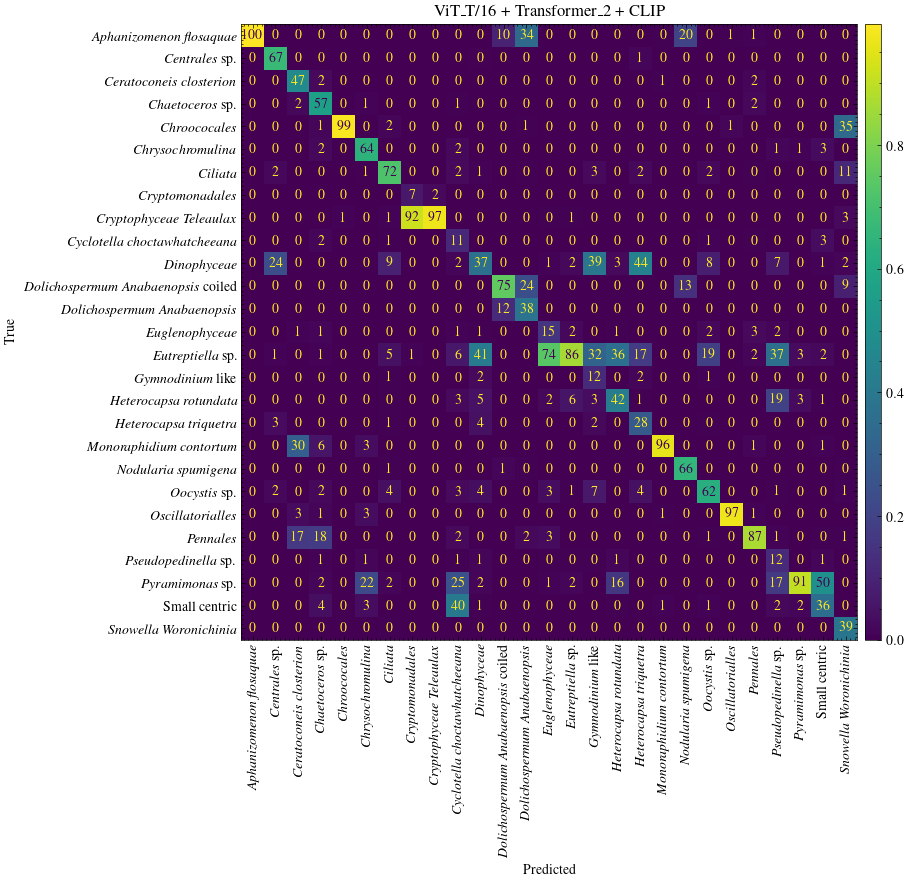

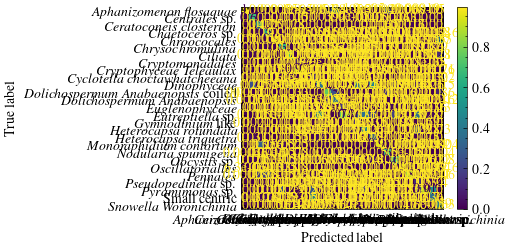

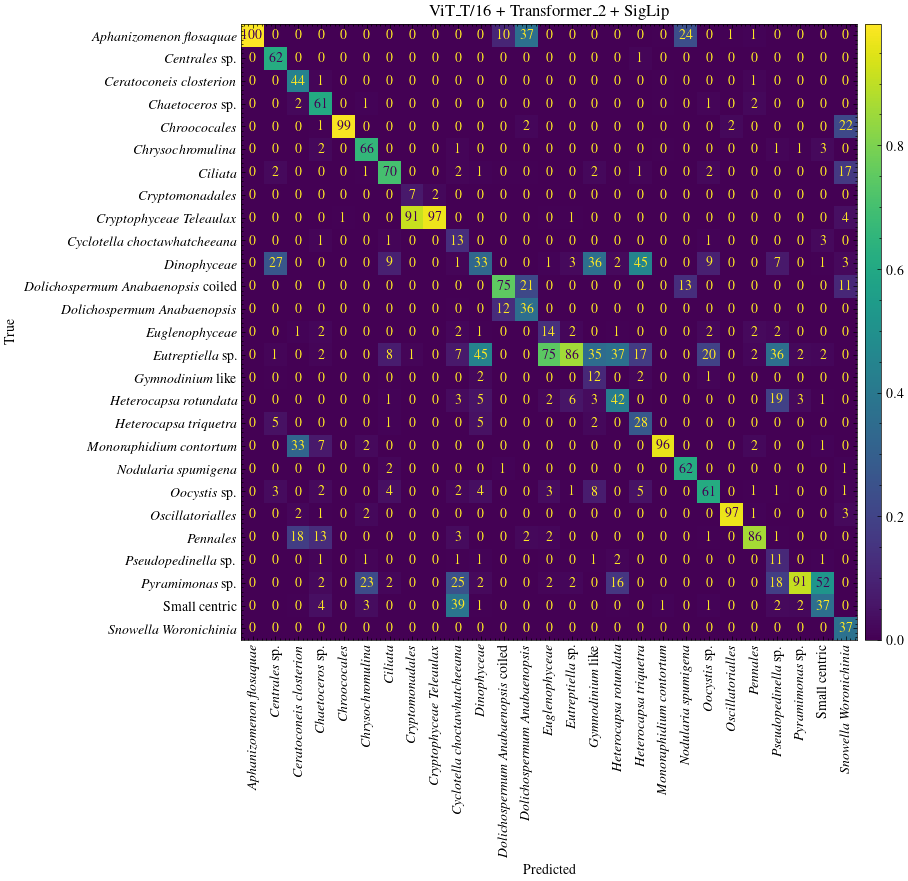

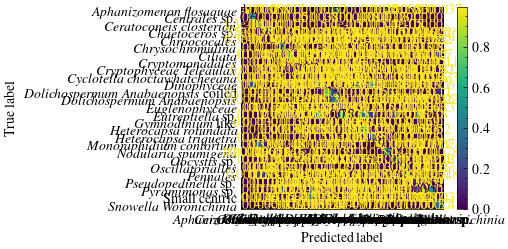

In [21]:
n, k = 16, 3 # <- change here
folds = FOLDS[:] # <- give fold(s) as a list
sims = SIMS[:] # <- give sim(s) as a list
normalize = 'pred' # <- also this: how to normalize confusion matrices
classes = [to_latex(to_latin(str(name))) for name in coder.classes_]

for name in NAMES:
    accs = {n: [] for n in N[1:]}
    true, pred = [], []
    for fold in tqdm(folds, desc=pretty_names[name]):
        sub = results[name][fold][n]
        for sim in sims:
            true.append(coder.transform(sub[sim]['true']))
            pred.append(coder.transform(sub[sim]['pred'][k]))

    true = np.concatenate(true)
    pred = np.concatenate(pred)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(pretty_names[name])

    cm = ConfusionMatrixDisplay.from_predictions(true, pred, display_labels=classes, normalize=normalize)
    cm.plot(ax=ax, colorbar=False, values_format='.0%')
    ax.tick_params(axis='x', labelrotation=90)
    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(cm.im_, cax=cax) # Similar to fig.colorbar(im, cax = cax)

    fig.savefig(f'figures/cm_{name}_lab.pdf')

## Classification reports, given $n$ and $k$

Optionally: specify the fold(s) and simulation(s)

In [59]:
n, k = 16, 3 # <- change here
folds = FOLDS[:] # <- give fold(s) as a list
sims = SIMS[:] # <- give sim(s) as a list
classes = [to_latin(str(name)) for name in coder.classes_]
# classes = [to_latex(to_latin(str(name))) for name in coder.classes_]


for name in NAMES[:]:
    accs = {n: [] for n in N[1:]}
    true, pred = [], []
    for fold in tqdm(folds, desc=pretty_names[name]):
        sub = results[name][fold][n]
        for sim in sims:
            true.append(coder.transform(sub[sim]['true']))
            pred.append(coder.transform(sub[sim]['pred'][k]))

    true = np.concatenate(true)
    pred = np.concatenate(pred)

    report = classification_report(true, pred, target_names=classes, digits=4, output_dict=True)
    accuracy = report.pop('accuracy')

    class_pad = len(max(map(to_latex, report), key=len))
    title_pad = 9

    print(f'{'Class':<{class_pad}} & {'Precision':<{title_pad}} & {'Recall':<{title_pad}} & {'F1-score':<{title_pad}} & {'Support':<{title_pad}} \\\\')

    for row, data in report.items():
        data['support'] /= report['weighted avg']['support']
        row = f'{to_latex(row):<{class_pad}}'
        row += f' & {data['precision']:<{title_pad - 1}.2%}'
        row += f' & {data['recall']:<{title_pad - 1}.2%}'
        row += f' & {data['f1-score']:<{title_pad - 1}.2%}'
        row += f' & {data['support']:<{title_pad - 1}.2%} \\\\'
        row = row.replace('%', '\\%')
        row = row.replace('\\textit{macro}', 'Macro')
        row = row.replace('\\textit{weighted}', 'Weighted')
        row = row.replace('\\textit{avg}', 'avg.')
        print(row)



EfficientNet_B0 + CNN_2 + CLIP: 100%|██████████| 5/5 [00:00<00:00,  9.16it/s]


Class                                                & Precision & Recall    & F1-score  & Support   \\
\textit{Aphanizomenon} \textit{flosaquae}            & 99.60\%   & 95.49\%   & 97.50\%   & 18.61\%   \\
\textit{Centrales} sp.                               & 60.72\%   & 87.40\%   & 71.66\%   & 0.17\%    \\
\textit{Ceratoconeis} \textit{closterion}            & 45.37\%   & 90.85\%   & 60.52\%   & 0.31\%    \\
\textit{Chaetoceros} sp.                             & 62.21\%   & 73.21\%   & 67.26\%   & 0.22\%    \\
\textit{Chroococales}                                & 96.84\%   & 95.79\%   & 96.32\%   & 9.30\%    \\
\textit{Chrysochromulina}                            & 64.88\%   & 92.12\%   & 76.14\%   & 1.47\%    \\
\textit{Ciliata}                                     & 70.93\%   & 61.34\%   & 65.79\%   & 0.57\%    \\
\textit{Cryptomonadales}                             & 6.88\%    & 61.20\%   & 12.37\%   & 1.20\%    \\
\textit{Cryptophyceae} \textit{Teleaulax}            & 97.22\%  

EfficientNet_B0 + CNN_2 + SigLip: 100%|██████████| 5/5 [00:00<00:00,  8.27it/s]


Class                                                & Precision & Recall    & F1-score  & Support   \\
\textit{Aphanizomenon} \textit{flosaquae}            & 99.55\%   & 95.42\%   & 97.44\%   & 18.61\%   \\
\textit{Centrales} sp.                               & 66.04\%   & 86.47\%   & 74.88\%   & 0.17\%    \\
\textit{Ceratoconeis} \textit{closterion}            & 45.39\%   & 93.70\%   & 61.16\%   & 0.31\%    \\
\textit{Chaetoceros} sp.                             & 60.75\%   & 72.74\%   & 66.20\%   & 0.22\%    \\
\textit{Chroococales}                                & 96.22\%   & 96.61\%   & 96.42\%   & 9.30\%    \\
\textit{Chrysochromulina}                            & 71.05\%   & 92.55\%   & 80.38\%   & 1.47\%    \\
\textit{Ciliata}                                     & 73.74\%   & 56.66\%   & 64.08\%   & 0.57\%    \\
\textit{Cryptomonadales}                             & 6.79\%    & 61.03\%   & 12.22\%   & 1.20\%    \\
\textit{Cryptophyceae} \textit{Teleaulax}            & 96.85\%  

ViT_T/16 + Transformer_2 + CLIP: 100%|██████████| 5/5 [00:00<00:00,  9.37it/s]


Class                                                & Precision & Recall    & F1-score  & Support   \\
\textit{Aphanizomenon} \textit{flosaquae}            & 99.62\%   & 96.27\%   & 97.92\%   & 18.61\%   \\
\textit{Centrales} sp.                               & 67.37\%   & 85.33\%   & 75.29\%   & 0.17\%    \\
\textit{Ceratoconeis} \textit{closterion}            & 47.13\%   & 88.48\%   & 61.50\%   & 0.31\%    \\
\textit{Chaetoceros} sp.                             & 56.76\%   & 55.26\%   & 56.00\%   & 0.22\%    \\
\textit{Chroococales}                                & 98.73\%   & 97.51\%   & 98.12\%   & 9.30\%    \\
\textit{Chrysochromulina}                            & 64.25\%   & 88.95\%   & 74.61\%   & 1.47\%    \\
\textit{Ciliata}                                     & 71.82\%   & 57.44\%   & 63.83\%   & 0.57\%    \\
\textit{Cryptomonadales}                             & 6.64\%    & 60.29\%   & 11.96\%   & 1.20\%    \\
\textit{Cryptophyceae} \textit{Teleaulax}            & 97.02\%  

ViT_T/16 + Transformer_2 + SigLip: 100%|██████████| 5/5 [00:00<00:00,  9.10it/s]


Class                                                & Precision & Recall    & F1-score  & Support   \\
\textit{Aphanizomenon} \textit{flosaquae}            & 99.68\%   & 95.83\%   & 97.72\%   & 18.61\%   \\
\textit{Centrales} sp.                               & 61.68\%   & 85.53\%   & 71.68\%   & 0.17\%    \\
\textit{Ceratoconeis} \textit{closterion}            & 43.69\%   & 91.63\%   & 59.17\%   & 0.31\%    \\
\textit{Chaetoceros} sp.                             & 60.57\%   & 55.21\%   & 57.76\%   & 0.22\%    \\
\textit{Chroococales}                                & 98.82\%   & 98.11\%   & 98.47\%   & 9.30\%    \\
\textit{Chrysochromulina}                            & 65.83\%   & 90.13\%   & 76.09\%   & 1.47\%    \\
\textit{Ciliata}                                     & 70.13\%   & 57.00\%   & 62.89\%   & 0.57\%    \\
\textit{Cryptomonadales}                             & 6.77\%    & 60.70\%   & 12.19\%   & 1.20\%    \\
\textit{Cryptophyceae} \textit{Teleaulax}            & 97.09\%  

# Display cross-modal results

First, run benchmark scripts needed in your case:

* `scripts/benchmark_cross.py`: No folds in test data.
* `scripts/benchmark_corss_folds.py`: Folds in test data.

Use `--help` for more details. Scripts also have few parameters to configure,
*if needed*.

After running script(s), you end up a following dict structures:

```
results = {
    model_name (str): {
        fold (Any): {
            n_per_class_in_gallery (int): subresults
            ...
        }
        ...
    } 
    ...
}
```
where
```
subresults = {
    simulation_id (Any): {
        'true': ndarray
        'pred': {
            k_neighbors_in_search (int): {
                configuration (any): ndarray
            }
            ...
        }
    }
    ... 
}
```

Similar to original result dict, but with additional layer which describes
which modalities gallery and test data includes.

Notation X - Y:
* gallery contains modality X
* test data contains modality Y
* Can be both: X+Y - Y, or any other combination

In [17]:
with open('./results_utomodels_with_lab_cross.pkl', 'rb') as buf:
    results = pickle.load(buf)

# Gather utility functions and variables, and configuration parameters

NAMES = list(results)
FOLDS = list(results[NAMES[0]])
N = list(results[NAMES[0]][FOLDS[0]])
SIMS = list(results[NAMES[0]][FOLDS[0]][N[-1]])
K = list(results[NAMES[0]][FOLDS[0]][N[-1]][SIMS[0]]['pred'])
SETUPS = list(results[NAMES[0]][FOLDS[0]][N[-1]][SIMS[0]]['pred'][K[0]])
coder = LabelEncoder().fit(results[NAMES[0]][FOLDS[0]][N[-1]][SIMS[0]]['true'])


def to_latin(key):
    key_new = key.replace('-', '_')
    key_new = key_new.replace(' ', '_')
    pieces = key_new.split('_')
    return ' '.join(pieces)

def to_latex(name):
    pieces = name.split(' ')
    if len(pieces) == 1:
        title = f'\\textit{{{name}}}'
    else:
        title = ('\\textit{{{}}} ' * len(pieces)).format(*pieces)[:-1]
    title = title.replace('\\textit{sp}', 'sp.')
    title = title.replace('\\textit{like}', 'like')
    title = title.replace('\\textit{single}', 'single')
    title = title.replace('\\textit{coiled}', 'coiled')
    title = title.replace('\\textit{Small}', 'Small')
    title = title.replace('\\textit{centric}', 'centric')
    return title

pretty_names = {
    'efficientnet_b0_cnn_2_512_clip_FASTVISION-plus': 'EfficientNet_B0 + CNN_2 + CLIP',
    'efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus': 'EfficientNet_B0 + CNN_2 + SigLip',
    'vit_t_16_transformer_2_512_clip_FASTVISION-plus': 'ViT_T/16 + Transformer_2 + CLIP',
    'vit_t_16_transformer_2_512_siglip_FASTVISION-plus': 'ViT_T/16 + Transformer_2 + SigLip',
    'efficientnet_b0_cnn_2_512_clip_CS_103_Uto2024': 'EfficientNet_B0 + CNN_2 + CLIP',
    'efficientnet_b0_cnn_2_512_siglip_CS_103_Uto2024': 'EfficientNet_B0 + CNN_2 + SigLip',
    'vit_t_16_transformer_2_512_clip_CS_103_Uto2024': 'ViT_T/16 + Transformer_2 + CLIP',
    'vit_t_16_transformer_2_512_siglip_CS_103_Uto2024': 'ViT_T/16 + Transformer_2 + SigLip',
}

print('NAMES =', ' | '.join(NAMES))
print('FOLDS =', ' | '.join(map(str, FOLDS)))
print('N =', ' | '.join(map(str, N)))
print('SIMS =', ' | '.join(map(str, SIMS)))
print('K =', ' | '.join(map(str, K)))
print('SETUPS =', ' | '.join(map(str, SETUPS)))

NAMES = efficientnet_b0_cnn_2_512_clip_CS_103_Uto2024 | efficientnet_b0_cnn_2_512_siglip_CS_103_Uto2024 | vit_t_16_transformer_2_512_clip_CS_103_Uto2024 | vit_t_16_transformer_2_512_siglip_CS_103_Uto2024
FOLDS = 1 | 2 | 3 | 4 | 5
N = 2 | 4 | 8 | 12 | 16
SIMS = 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
K = 1 | 3 | 5 | 7 | 9
SETUPS = I - I | I - P | I - I+P | P - I | P - P | P - I+P | I+P - I | I+P - P


## Dense table, given $n$ and $k$

Optionally, fold(s), sim(s) and setup(s)

See from output above which parameters are available

In [74]:
n = 16 # <- change here
k = 3
folds = FOLDS[:] # <- give fold(s) as a list
sims = SIMS[:] # <- give sim(s) as a list
setups = SETUPS[:] # <- give sim(s) as a list
metrics = {}

for name in NAMES:
    metrics[name] = {setup: [] for setup in setups}
    for fold in folds:
        sub = results[name][fold][n]
        for sim in sims:
            true = coder.transform(sub[sim]['true'])
            for setup in setups:
                pred = coder.transform(sub[sim]['pred'][k][setup])
                acc = accuracy_score(true, pred)
                rest = precision_recall_fscore_support(true, pred, average='macro', warn_for=[])
                metrics[name][setup].append((acc,) + rest[:-1])

    print(f'{pretty_names[name]}:')
    for setup in setups:
        data = metrics[name][setup]
        mu = np.mean(data, 0)
        std = np.std(data, 0)
        vals = chain(*zip(mu, std))
        print((' {:<3s}' * 2).format(*setup.split(' - ')) + (' {:6.2%}' * 8).format(*vals))
    print()


EfficientNet_B0 + CNN_2 + CLIP:
 I   I   72.54%  1.13% 72.41%  1.05% 72.35%  1.11% 71.69%  1.13%
 I   P   15.62%  2.63% 17.62%  3.37% 15.68%  2.53% 13.06%  2.38%
 I   I+P 71.35%  1.10% 71.41%  1.08% 70.90%  1.08% 70.43%  1.15%
 P   I   14.41%  1.71% 13.98%  3.13% 15.03%  1.78% 10.43%  2.31%
 P   P   86.27%  0.87% 85.59%  0.93% 85.23%  0.91% 85.04%  0.95%
 P   I+P 85.74%  0.93% 85.12%  0.99% 84.67%  0.99% 84.52%  1.03%
 I+P I   72.32%  1.12% 72.19%  1.05% 72.14%  1.09% 71.47%  1.12%
 I+P P   86.16%  0.87% 85.47%  0.93% 85.13%  0.90% 84.93%  0.94%

EfficientNet_B0 + CNN_2 + SigLip:
 I   I   71.88%  1.02% 71.85%  1.00% 71.72%  1.02% 71.09%  1.02%
 I   P   14.81%  2.77% 16.66%  3.95% 15.13%  2.73% 12.43%  2.77%
 I   I+P 70.79%  1.07% 70.84%  1.05% 70.54%  1.05% 69.94%  1.06%
 P   I   16.30%  1.81% 14.16%  2.56% 16.46%  1.71% 11.65%  1.57%
 P   P   86.18%  0.67% 85.58%  0.69% 85.26%  0.69% 85.09%  0.70%
 P   I+P 85.89%  0.72% 85.38%  0.69% 84.96%  0.74% 84.84%  0.73%
 I+P I   71.70%  1.01% 

## Classification reports, given $n$, $k$ and setup

Optionally: specify the fold(s) and simulation(s)

In [30]:
n, k, setup = 16, 3, 'I - I' # <- change here
f = FOLDS[:] # <- give fold(s) as a list
s = SIMS[:] # <- give sim(s) as a list
classes = [to_latin(str(name)) for name in coder.classes_]
# classes = [to_latex(to_latin(str(name))) for name in coder.classes_]


for name in NAMES[:]:
    accs = {n: [] for n in N[1:]}
    true, pred = [], []
    for fold in tqdm(FOLDS, desc=pretty_names[name]):
        if fold not in f: continue
        sub = results[name][fold][n]
        for sim in SIMS:
            if sim not in s: continue
            true.append(coder.transform(sub[sim]['true']))
            pred.append(coder.transform(sub[sim]['pred'][k][setup]))

    true = np.concatenate(true)
    pred = np.concatenate(pred)

    report = classification_report(true, pred, target_names=classes, digits=4, output_dict=True, zero_division=0)
    accuracy = report.pop('accuracy')

    class_pad = len(max(map(to_latex, report), key=len))
    title_pad = 9

    print(f'{'Class':<{class_pad}} & {'Precision':<{title_pad}} & {'Recall':<{title_pad}} & {'F1-score':<{title_pad}} & {'Support':<{title_pad}} \\\\')

    for row, data in report.items():
        data['support'] /= report['weighted avg']['support']
        row = f'{to_latex(row):<{class_pad}}'
        row += f' & {data['precision']:<{title_pad - 1}.2%}'
        row += f' & {data['recall']:<{title_pad - 1}.2%}'
        row += f' & {data['f1-score']:<{title_pad - 1}.2%}'
        row += f' & {data['support']:<{title_pad - 1}.2%} \\\\'
        row = row.replace('%', '\\%')
        row = row.replace('\\textit{macro}', 'Macro')
        row = row.replace('\\textit{weighted}', 'Weighted')
        row = row.replace('\\textit{avg}', 'avg.')
        print(row)



EfficientNet_B0 + CNN_2 + CLIP: 100%|██████████| 5/5 [00:00<00:00, 82.67it/s]


Class                                                & Precision & Recall    & F1-score  & Support   \\
\textit{Aphanizomenon} \textit{flosaquae}            & 99.80\%   & 96.93\%   & 98.34\%   & 18.61\%   \\
\textit{Centrales} sp.                               & 49.64\%   & 92.67\%   & 64.65\%   & 0.17\%    \\
\textit{Ceratoconeis} \textit{closterion}            & 81.73\%   & 97.78\%   & 89.04\%   & 0.31\%    \\
\textit{Chaetoceros} sp.                             & 71.06\%   & 87.89\%   & 78.59\%   & 0.22\%    \\
\textit{Chroococales}                                & 99.96\%   & 94.51\%   & 97.16\%   & 9.30\%    \\
\textit{Chrysochromulina}                            & 76.11\%   & 91.15\%   & 82.95\%   & 1.47\%    \\
\textit{Ciliata}                                     & 53.52\%   & 53.20\%   & 53.36\%   & 0.57\%    \\
\textit{Cryptomonadales}                             & 7.17\%    & 53.02\%   & 12.63\%   & 1.20\%    \\
\textit{Cryptophyceae} \textit{Teleaulax}            & 95.44\%  

EfficientNet_B0 + CNN_2 + SigLip: 100%|██████████| 5/5 [00:00<00:00, 87.97it/s]


Class                                                & Precision & Recall    & F1-score  & Support   \\
\textit{Aphanizomenon} \textit{flosaquae}            & 99.76\%   & 96.43\%   & 98.07\%   & 18.61\%   \\
\textit{Centrales} sp.                               & 52.92\%   & 84.67\%   & 65.13\%   & 0.17\%    \\
\textit{Ceratoconeis} \textit{closterion}            & 77.52\%   & 99.63\%   & 87.20\%   & 0.31\%    \\
\textit{Chaetoceros} sp.                             & 79.08\%   & 81.58\%   & 80.31\%   & 0.22\%    \\
\textit{Chroococales}                                & 99.94\%   & 95.55\%   & 97.69\%   & 9.30\%    \\
\textit{Chrysochromulina}                            & 80.21\%   & 92.92\%   & 86.10\%   & 1.47\%    \\
\textit{Ciliata}                                     & 51.42\%   & 57.80\%   & 54.43\%   & 0.57\%    \\
\textit{Cryptomonadales}                             & 6.54\%    & 53.49\%   & 11.66\%   & 1.20\%    \\
\textit{Cryptophyceae} \textit{Teleaulax}            & 95.47\%  

ViT_T/16 + Transformer_2 + CLIP: 100%|██████████| 5/5 [00:00<00:00, 104.16it/s]


Class                                                & Precision & Recall    & F1-score  & Support   \\
\textit{Aphanizomenon} \textit{flosaquae}            & 99.66\%   & 97.00\%   & 98.31\%   & 18.61\%   \\
\textit{Centrales} sp.                               & 53.78\%   & 90.00\%   & 67.33\%   & 0.17\%    \\
\textit{Ceratoconeis} \textit{closterion}            & 78.42\%   & 95.56\%   & 86.14\%   & 0.31\%    \\
\textit{Chaetoceros} sp.                             & 64.62\%   & 72.11\%   & 68.16\%   & 0.22\%    \\
\textit{Chroococales}                                & 99.97\%   & 95.40\%   & 97.63\%   & 9.30\%    \\
\textit{Chrysochromulina}                            & 68.99\%   & 88.15\%   & 77.41\%   & 1.47\%    \\
\textit{Ciliata}                                     & 42.98\%   & 52.00\%   & 47.06\%   & 0.57\%    \\
\textit{Cryptomonadales}                             & 6.73\%    & 53.49\%   & 11.95\%   & 1.20\%    \\
\textit{Cryptophyceae} \textit{Teleaulax}            & 94.92\%  

ViT_T/16 + Transformer_2 + SigLip: 100%|██████████| 5/5 [00:00<00:00, 106.00it/s]


Class                                                & Precision & Recall    & F1-score  & Support   \\
\textit{Aphanizomenon} \textit{flosaquae}            & 99.63\%   & 96.07\%   & 97.81\%   & 18.61\%   \\
\textit{Centrales} sp.                               & 42.41\%   & 89.33\%   & 57.51\%   & 0.17\%    \\
\textit{Ceratoconeis} \textit{closterion}            & 72.30\%   & 96.67\%   & 82.73\%   & 0.31\%    \\
\textit{Chaetoceros} sp.                             & 56.74\%   & 64.21\%   & 60.25\%   & 0.22\%    \\
\textit{Chroococales}                                & 99.90\%   & 95.98\%   & 97.90\%   & 9.30\%    \\
\textit{Chrysochromulina}                            & 68.51\%   & 93.54\%   & 79.09\%   & 1.47\%    \\
\textit{Ciliata}                                     & 39.39\%   & 54.20\%   & 45.62\%   & 0.57\%    \\
\textit{Cryptomonadales}                             & 6.81\%    & 55.47\%   & 12.13\%   & 1.20\%    \\
\textit{Cryptophyceae} \textit{Teleaulax}            & 94.63\%  

# Visualize multimodal embedding space

In [1]:
with open('./embeddings_utomodels_with_lab_raw.pkl', 'rb') as buf:
    embeddings = pickle.load(buf)

MODELS = list(embeddings)
FOLDS = list(embeddings[MODELS[0]])

coder = LabelEncoder().fit(embeddings[MODELS[0]][FOLDS[0]]['classes'])

def get_cmap(n, name='turbo'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.get_cmap(name, n)

def to_latin(key):
    key_new = key.replace('-', '_')
    key_new = key_new.replace(' ', '_')
    pieces = key_new.split('_')
    return ' '.join(pieces)

def to_latex(name):
    pieces = name.split(' ')
    if len(pieces) == 1:
        title = f'\\textit{{{name}}}'
    else:
        title = ('\\textit{{{}}} ' * len(pieces)).format(*pieces)[:-1]
    title = title.replace('\\textit{sp}', 'sp.')
    title = title.replace('\\textit{like}', 'like')
    title = title.replace('\\textit{single}', 'single')
    title = title.replace('\\textit{coiled}', 'coiled')
    title = title.replace('\\textit{Small}', 'Small')
    title = title.replace('\\textit{centric}', 'centric')
    return title

print('MODELS = ', ' | '.join(MODELS))
print('FOLDS = ', ' | '.join(map(str, FOLDS)))

NameError: name 'pickle' is not defined

In [154]:
model = 'vit_t_16_transformer_2_512_siglip_CS_103_Uto2024'
fold = 1
split = 'test' # if you are using datasets with folds

data = embeddings[model][fold]
# data = embeddings[model][fold][split]

image = data['image']
profile = data['profile']
name = data['label']
label = coder.transform(name)

combined = np.concatenate((image, profile))
label_tile = np.tile(label, (2,))

In [155]:
# Want to sample?

def sample(y, n):
    idx = []
    orig = np.arange(len(y))
    for label in np.unique(y):
        i = list(orig[y == label])
        j = random.sample(i, min(len(i), n))
        idx.extend(j)
    return np.array(idx)

idx = sample(label, 128)

image = image[idx]
profile = profile[idx]
name = name[idx]
label = coder.transform(name)

combined = np.concatenate((image, profile))
label_tile = np.tile(label, (2,))

In [156]:
mapping = TSNE(2)
# mapping = PCA(2)
# mapping = PaCMAP(2)

# reduced = mapping.fit_transform(combined)
# reduced = mapping.fit_transform(image)
reduced = mapping.fit_transform(profile)

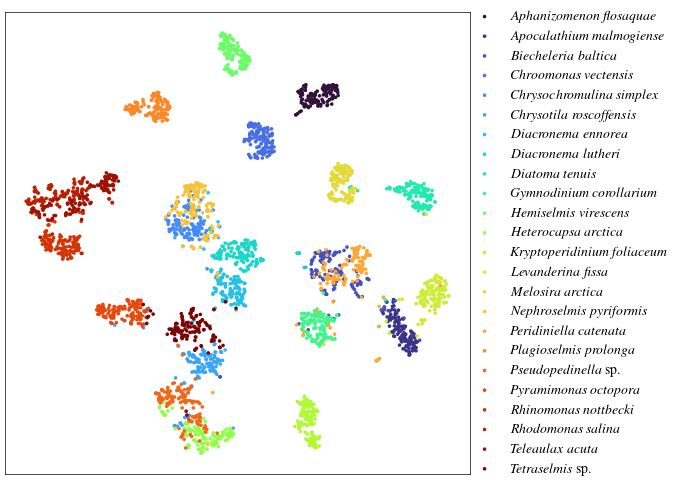

In [157]:
# full
manifold = reduced[:]
C = label[:]
# C = label_tile[:]

# images from full space
# stop = len(reduced) // 2
# manifold = reduced[:stop]
# C = label_tile[:stop]

# profile from full space
# stop = len(reduced) // 2
# manifold = reduced[stop:]
# C = label_tile[stop:]

cmap = get_cmap(len(np.unique(label)))

fig, ax = plt.subplots(figsize=(6, 6))
for c in np.unique(C):
    mask = C == c
    points = manifold[mask]
    ax.scatter(
        *points.T,
        c=(cmap(c),) * len(points),
        s=10,
        marker='.',
        edgecolors=None,
        label=to_latex(to_latin(str(coder.inverse_transform([c])[0])))
    )

ax.set_xticks([], [])
ax.set_yticks([], [])

# sea data
# ax.legend(loc='center right', bbox_to_anchor=(2, 0.5), ncols=2, columnspacing=0)

# lab data
ax.legend(loc='center right', bbox_to_anchor=(1.45, 0.5), ncols=1, columnspacing=0)
